In [3]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import sys
sys.path.append('../')

from generator_modules.load_dataset import load_ds

SEED: int = 42

PATH: str = '../data/transformed/'

START: str = '2024-06-11'
END: str = '2024-09-14'

print("Reading files...")
transactions_df: pd.DataFrame = load_ds(PATH, START, END)
print("Transactions read from files: ", len(transactions_df))
print("Fraudulent transactions: ", transactions_df.IS_FRAUD.sum())

Reading files...
Transactions read from files:  726864
Fraudulent transactions:  5106


In [4]:
columns_to_exclude: list = ['TRX_ID', 'CLIENT_ID', 'TERMINAL_ID', 'IS_FRAUD', 'FRAUD_SCENARIO', 'TRX_DATETIME', 'TRX_SECONDS', 'TRX_DAYS']

input_features: list = [col for col in transactions_df.columns if col not in columns_to_exclude]
output_features: str = 'IS_FRAUD'

In [5]:
import datetime

start_date_training: datetime = datetime.datetime.strptime("2024-07-25", "%Y-%m-%d")

from classification_modules.classificationClass import Classification

classificate: Classification = Classification()

In [6]:
import torch

if torch.cuda.is_available():
    device: str = "cuda" 
else:
    device = "cpu"
print("Selected device is",device)

Selected device is cuda


In [7]:
from deepLearning_modules.seeder import seed_everything

seed_everything(SEED)

In [8]:
from deepLearning_modules.transactionMLP import TransactionMLP

criterion: torch.nn.BCELoss = torch.nn.BCELoss().to(device)

In [9]:
from classification_modules.normaliser import normalize_data

training_duration=7
delay_duration=7
test_duration=7

delta_valid = test_duration

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delay_duration+delta_valid))

(train_set, valid_set)=classificate.split_train_test(transactions_df,start_date_training_with_valid,
                                       training_duration=training_duration,delay_duration=delay_duration,test_duration=test_duration)

(train_set, valid_set)=normalize_data(train_set, valid_set, input_features)

In [10]:
import torch.optim.lr_scheduler as lr_scheduler

from deepLearning_modules.training_tools import prepare_data_loaders

seed_everything(SEED)

model_name: str = 'best_sgd.pth'

model = TransactionMLP(len(input_features)).to(device)

trainer, validator = prepare_data_loaders(train_df=train_set, valid_df=valid_set, input_features=input_features, output_feature=output_features, batch_size=64, device=device)

criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
from deepLearning_modules.training_tools import train_model_earlystopping_metrics

results = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=1000, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = results['model']
training_time = results['training_time']
train_loss = results['train_losses']
valid_loss = results['valid_losses']

Epoch 1/1000: train loss: 0.29018364672882874
New best score: 0.12078339235981894
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 2/1000: train loss: 0.08813489208160878
New best score: 0.07142218386662454
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 3/1000: train loss: 0.0599246056205466
New best score: 0.05602651071704304
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 4/1000: train loss: 0.04912274172625952
New best score: 0.04891271053145601
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 5/1000: train loss: 0.04360271708712136
New best score: 0.04497418852297401
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 6/1000: train loss: 0.04033845664122031
New best score: 0.042536015870192026
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 7/1000: train loss: 0.038226439140085215
New best score: 0.040921606461396705
Model checkpoint saved at: ./models/best/best_sgd.pth
Epoch 8/1000: train loss: 0.03677408330524489


In [12]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {results['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {results['final_metrics']['precision']:.4f}\n"
          f"Recall: {results['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {results['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {results['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {results['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {results['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9968
Precision: 0.8991
Recall: 0.5269
F1 Score: 0.6644
AUC-ROC: 0.8340
Average Precision: 0.5894
Top-K Accuracy: 0.9800


In [13]:
from deepLearning_modules.training_tools import train_model_earlystopping_metrics

seed_everything(SEED)

model_name = 'best_adam.pth'

model = TransactionMLP(len(input_features)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

results = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=1000, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = results['model']
training_time = results['training_time']
train_loss_adam = results['train_losses']
valid_loss_adam = results['valid_losses']

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000: train loss: 0.6180878223278337
New best score: 0.4177078237673025
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 2/1000: train loss: 0.3089864683790467
New best score: 0.22364672536678587
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 3/1000: train loss: 0.17248419480203797
New best score: 0.13004864336798536
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 4/1000: train loss: 0.10439304817513487
New best score: 0.08128641376239884
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 5/1000: train loss: 0.06801634005368148
New best score: 0.0544003805485182
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 6/1000: train loss: 0.04756757928372159
New best score: 0.03889107208178382
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 7/1000: train loss: 0.03577285479869858
New best score: 0.03014341457561834
Model checkpoint saved at: ./models/best/best_adam.pth
Epoch 8/1000: train loss: 0.02889789681468134

In [14]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {results['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {results['final_metrics']['precision']:.4f}\n"
          f"Recall: {results['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {results['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {results['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {results['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {results['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9969
Precision: 0.8315
Recall: 0.5968
F1 Score: 0.6948
AUC-ROC: 0.8511
Average Precision: 0.6436
Top-K Accuracy: 0.9700


(0.01, 0.06)

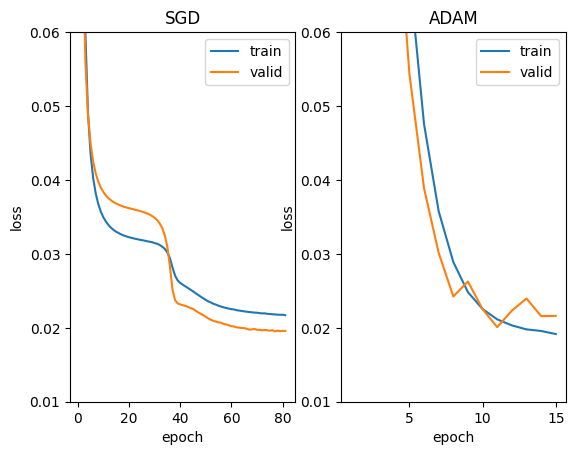

In [15]:
import numpy as np

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss))+1, train_loss)
plt.plot(np.arange(len(valid_loss))+1, valid_loss)
plt.title("SGD")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

plt.subplot(1, 2, 2) 
plt.plot(np.arange(len(train_loss_adam))+1, train_loss_adam)
plt.plot(np.arange(len(valid_loss_adam))+1, valid_loss_adam)
plt.title("ADAM")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

In [16]:
import torch.optim.lr_scheduler as lr_scheduler

from deepLearning_modules.transactionMLPDropoutClass import TransactionMLPWithDropout

model_name = 'best_dropout.pth'

seed_everything(SEED)
model: TransactionMLPWithDropout = TransactionMLPWithDropout(len(input_features), 0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

resultz = train_model_earlystopping_metrics(model=model, trainer=trainer, validator=validator, optimizer=optimizer, criterion=criterion, patience=3, max_epochs=1000, verbose=True, model_name=model_name, scheduler=scheduler)

trained_model = resultz['model']
training_time = resultz['training_time']
train_loss_dropout = resultz['train_losses']
valid_loss_dropout = resultz['valid_losses']

c:\Users\gc042\OneDrive\Desktop\Projects\datamining_proj\datamining_proj\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000: train loss: 0.6184049538307782
New best score: 0.41831191373195303
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 2/1000: train loss: 0.30972131476969733
New best score: 0.2256174362231077
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 3/1000: train loss: 0.17420906825858473
New best score: 0.132778953560868
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 4/1000: train loss: 0.10685575290855549
New best score: 0.08379394633912099
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 5/1000: train loss: 0.07133126338752843
New best score: 0.056706363590004395
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 6/1000: train loss: 0.05085418621815832
New best score: 0.04044468934504965
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 7/1000: train loss: 0.03963915186628405
New best score: 0.032601119706553085
Model checkpoint saved at: ./models/best/best_dropout.pth
Epoch 8/1000: train lo

In [17]:
print(f"Final Validation Metrics:\n"
          f"Accuracy: {resultz['final_metrics']['accuracy']:.4f}\n"
          f"Precision: {resultz['final_metrics']['precision']:.4f}\n"
          f"Recall: {resultz['final_metrics']['recall']:.4f}\n"
          f"F1 Score: {resultz['final_metrics']['f1']:.4f}\n"
          f"AUC-ROC: {resultz['final_metrics']['auc_roc']:.4f}\n"
          f"Average Precision: {resultz['final_metrics']['average_precision']:.4f}\n"
          f"Top-K Accuracy: {resultz['final_metrics']['top_k_accuracy']:.4f}")

Final Validation Metrics:
Accuracy: 0.9967
Precision: 0.9766
Recall: 0.4489
F1 Score: 0.6151
AUC-ROC: 0.8597
Average Precision: 0.6166
Top-K Accuracy: 0.9700


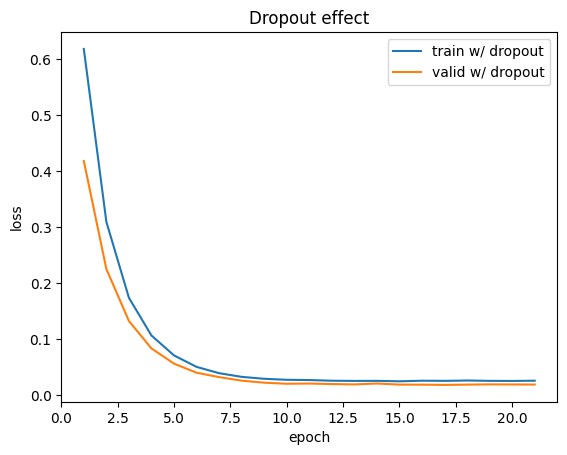

In [18]:
plt.plot(np.arange(len(train_loss_dropout))+1, train_loss_dropout)
plt.plot(np.arange(len(valid_loss_dropout))+1, valid_loss_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/ dropout','valid w/ dropout'])

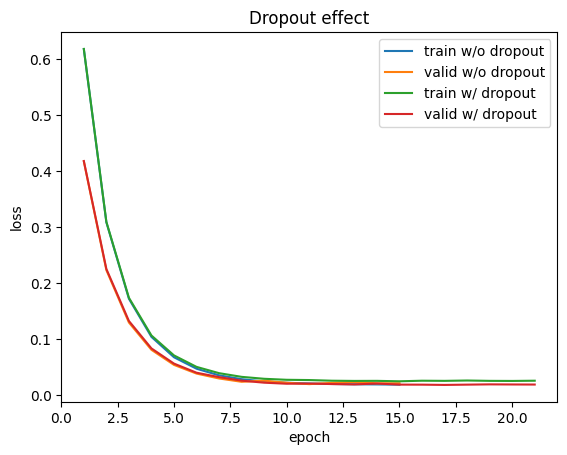

In [19]:
plt.plot(np.arange(len(train_loss_adam))+1, train_loss_adam)
plt.plot(np.arange(len(valid_loss_adam))+1, valid_loss_adam)
plt.plot(np.arange(len(train_loss_dropout))+1, train_loss_dropout)
plt.plot(np.arange(len(valid_loss_dropout))+1, valid_loss_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o dropout','valid w/o dropout','train w/ dropout','valid w/ dropout'])